# Projet d'Intelligence Artificielle : Classification d'Images de Tournesols et Choux-fleurs

<img src="https://shop.wattsfarms.co.uk/cdn/shop/products/cauliflower_649x.png?v=1584661455" alt="Image de chou-fleur" width="300" height="300"/> | <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTnAYKgQRDPyZUWjDzDpdmcg55hoRQ1pFOyQGa6FhAJlQ&s" alt="Image de tournesol" width="300" height="300"/>
--- | ---

## Auteurs

- [Antoine](https://github.com/Sechelige)
- [Lucas](https://github.com/lucasfariafr)
- [Gaëtan](https://github.com/goueyeya)

## Spécification

Le projet vise à développer une application capable d'identifier si une image contient un tournesol, un chou-fleur, ou autre chose. Les images peuvent avoir des dimensions variables, allant de 128×128 pixels à d'autres tailles.

## Jeu de Données

Le jeu de données peut être choisi librement, mais des jeux de données de tournesols et de choux-fleurs sont disponibles aux liens suivants :
- [Choux-fleurs](https://data.mendeley.com/datasets/t5sssfgn2v/3)
- [Tournesols](https://cours.iut-orsay.fr/mod/resource/view.php?id=54534&forceview=1)

## Attendus

Nous devons produire :
- Un compte-rendu de développement.
- Un Notebook en Python permettant de créer un modèle de reconnaissance d'image, entraîné selon les spécifications, sous forme d'un ou plusieurs fichiers.
- Une application utilisant le modèle entraîné pour traiter une image, avec le nom du fichier en argument pour les programmes C++ ou Java, ou le fichier chargé dans la page Web pour une application JavaScript. Le résultat de l'identification doit être affiché avec un coefficient de certitude sur la classe identifiée.

## Technologies de Déploiement

Pour ce projet, nous avons utilisé Java comme technologie de déploiement, nous avons realiser une petite interface graphique en java pour pouvoir tester notre modèle.

## Transfer learning
Il faut définir et instancier un réseau de neurones pour faire du *transfer learning*.

Comme on l'a vu, il est souvent préférable d'ajouter de la *régularisation* au modèle qui ava être utilisé pour faire du *transfer learning* :

In [1]:
import os
import tempfile
from keras.models import model_from_json
from keras.regularizers import l2
import tensorflow as tf

def add_regularization(model, regularizer=l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
        return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

## Choix du réseau pré-entrainé

Il faut en fait choisir celui-ci en fonction des capacités de la bibliothèque qui sera utilisée pour le déploiement afin d'être sûr qu'on pourra charger et utiliser le modèle.
(Utiliser les versions les plus récentes et faires des essais avant de passer du temps à entrainer !)

In [2]:
import keras
from keras import applications
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Flatten

def build_mobilenet_transfert(width, height, depth, classes):
    (input_shape, chan_dim)=  ((depth, height, width), 1) if keras.backend.image_data_format() == "channels_first" \
    else ((height, width, depth), -1)
    new_input = Input(shape=input_shape)
    base_model = applications.MobileNetV3Small(input_shape=(224, 224, 3),
                                                     alpha=1.0,
                                                    minimalistic= True,
                                                    include_top=False,
                                                    weights="imagenet",
                                                    dropout_rate=0.2,
                                                    include_preprocessing=True)
    base_model = add_regularization(base_model)
    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    add_model.add(Dense(256, activation='relu'))
    add_model.add(Dense(classes, activation='sigmoid'))
    model = keras.Model(inputs=base_model.input, outputs=add_model(base_model.output))
    for layer in model.layers[:-5]:
        layer.trainable = False
    return model

model_mobilenet= build_mobilenet_transfert(224,224,3,3)
print (model_mobilenet.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                    

## Jeu de données

[constituer un jeu de données à partir des fichiers dans les répertoires](https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function)


Found 5442 files belonging to 3 classes.


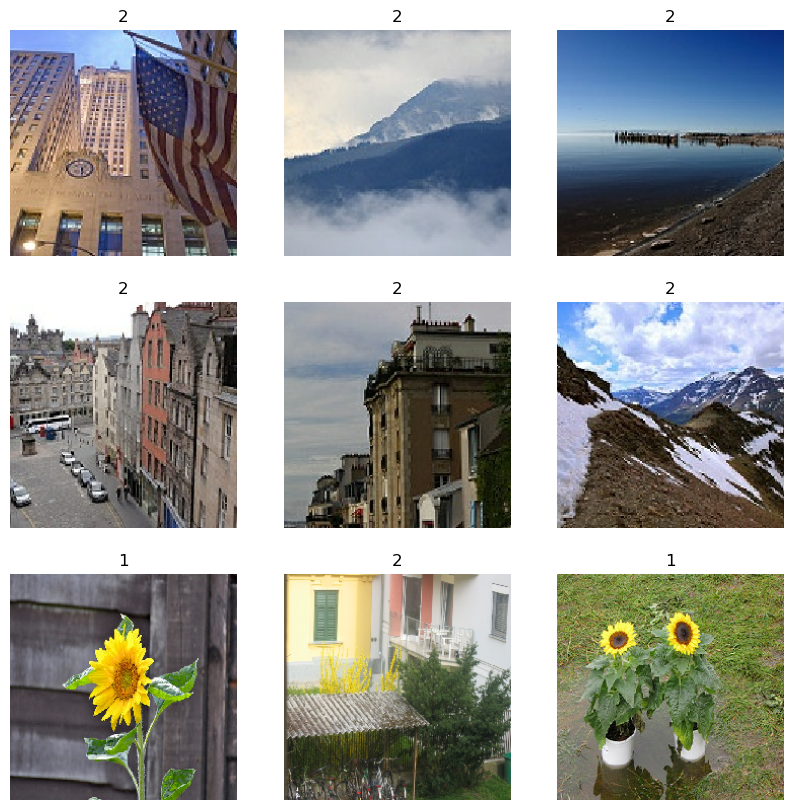

In [6]:
import numpy as np
from keras import utils as ut
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Fonction pour charger les images à partir du répertoire
def load_images_from_folder(directory):
    images, labels = [], []
    dataset = ut.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        color_mode='rgb', # ou "grayscale"
        class_names=['Choux-fleurs', 'Tournesols', 'Autres'],
        image_size=(224, 224),  
        batch_size=32, # nombre d'images à lire à chaque fois,
        shuffle=True,
        interpolation='nearest'

    )
    #cette boucle parcourt l'ensemble du jeu de données par lots, 
    # extrait les images et les étiquettes de chaque lot, 
    # les convertit en tableaux NumPy, 
    # puis les ajoute à des listes images et labels
    for lot_image, lot_label in dataset:
        images.extend(lot_image.numpy())
        labels.extend(lot_label.numpy())
    
    return np.array(images), np.array(labels)
    #return dataset#
   

# Chargement des images de tournesols depuis le répertoire
images, labels = load_images_from_folder('./images')

# Affichage de quelques images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
plt.show()


## Entrainement
Entrainer le modèle.

In [16]:
# Diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Compilation du modèle
model_mobilenet.compile(loss='sparse_categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

# Entraînement du modèle
history = model_mobilenet.fit(train_images, train_labels,
                              batch_size=32,
                              epochs=20,
                              validation_data=(test_images, test_labels))

# Évaluation du modèle sur l'ensemble de test
evaluation = model_mobilenet.evaluate(test_images, test_labels)

# Affichage des métriques d'évaluation (par exemple, perte et précision)
print(f'Loss: {evaluation[0]}')
print(f'Accuracy: {evaluation[1]}')

Epoch 1/20
137/137 [==============================] - 13s 86ms/step - loss: 0.6328 - accuracy: 0.9991 - val_loss: 1.0122 - val_accuracy: 0.9192
Epoch 2/20
137/137 [==============================] - 11s 83ms/step - loss: 0.8582 - accuracy: 0.9938 - val_loss: 0.9975 - val_accuracy: 0.9688
Epoch 3/20
137/137 [==============================] - 12s 85ms/step - loss: 0.7307 - accuracy: 0.9972 - val_loss: 0.8105 - val_accuracy: 0.9881
Epoch 4/20
137/137 [==============================] - 12s 88ms/step - loss: 0.6749 - accuracy: 0.9982 - val_loss: 0.7347 - val_accuracy: 0.9917
Epoch 5/20
137/137 [==============================] - 12s 87ms/step - loss: 0.5966 - accuracy: 0.9998 - val_loss: 0.7725 - val_accuracy: 0.9908
Epoch 6/20
137/137 [==============================] - 12s 87ms/step - loss: 0.6215 - accuracy: 0.9998 - val_loss: 0.7790 - val_accuracy: 0.9917
Epoch 7/20
137/137 [==============================] - 12s 88ms/step - loss: 0.6450 - accuracy: 0.9975 - val_loss: 0.7634 - val_accuracy:

## TEST DU MODELE

1/1 [==============================] - 0s 239ms/step
Classe prédite : Choux-fleurs


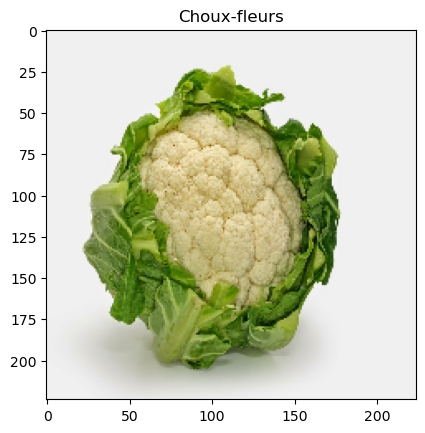

1/1 [==============================] - 0s 17ms/step
Classe prédite : Tournesols


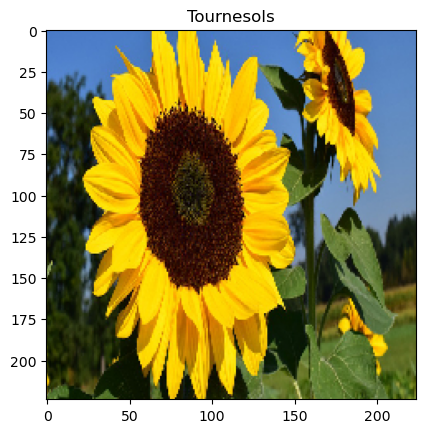

1/1 [==============================] - 0s 56ms/step
Classe prédite : Autres


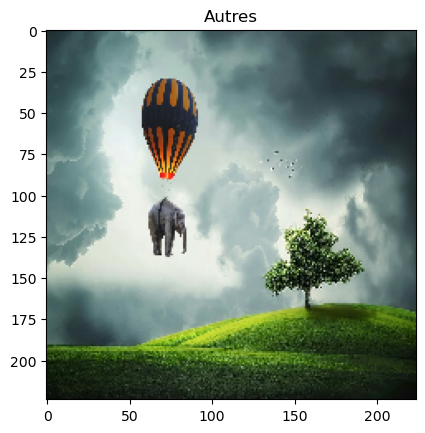

1/1 [==============================] - 0s 24ms/step
Classe prédite : Autres


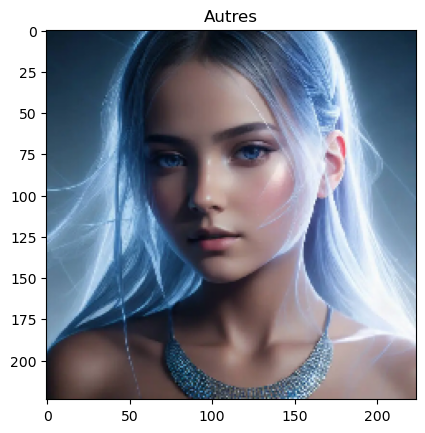

1/1 [==============================] - 0s 17ms/step
Classe prédite : Autres


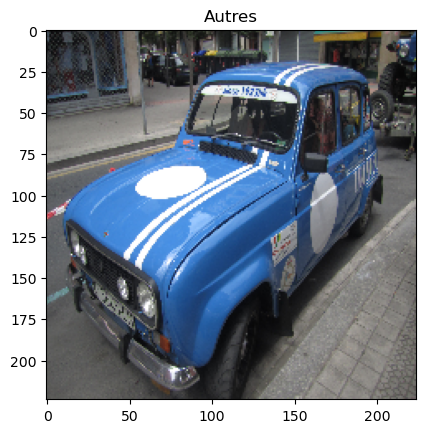

In [17]:
from keras.preprocessing import image as keras_image


def predict_image(image_path):
    img = keras_image.load_img(image_path, target_size=(224, 224))  # Redimensionner l'image à 224x224 pixels
    img_array = keras_image.img_to_array(img)

    # Ajouter une dimension pour correspondre à la forme attendue par le modèle
    img_array = np.expand_dims(img_array, axis=0)

    # Faire une prédiction avec votre modèle
    predictions = model_mobilenet.predict(img_array)

    # Afficher les prédictions
    class_names = ['Choux-fleurs', 'Tournesols', 'Autres']  # Liste des noms de classe
    predicted_class = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class]

    print(f'Classe prédite : {predicted_class_name}')
    plt.imshow(img)
    plt.title(predicted_class_name)
    plt.show()
    

predict_image('./image_test/chou.jpg')
predict_image('./image_test/tournesol.png')
predict_image('./image_test/elephant.png')
predict_image('./image_test/madame.png')
predict_image('./image_test/vroum.jpg')

## Sauvegarde du modèle entrainté

In [91]:
model_mobilenet.save("mobilenet_with-preprocessing.h5")

/Users/antoinedeurveilher/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Conversion de la sauvegarde en un format pour l'inférence

Pour utilise le modèle entrainé en inférence seule, en phase de déploiement, on fait une conversion du fichier :

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np                    
#path of the directory where you want to save your model
frozen_out_path = './freez/'             # name of the .pb file
frozen_graph_filename = "model" #“frozen_graph”

model = keras.models.load_model("model_sauv/mobilenet_with-preprocessing.h5")#load_model("./cls_vgg16_6_cl.h5")
# model = ""# Your model# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 60)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
    print("-" * 60)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)# Save frozen graph to disk
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pb",
                  as_text=False)# Save its text representation
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                logdir=frozen_out_path,
                name=f"{frozen_graph_filename}.pbtxt",
                as_text=True)


2023-12-15 14:55:57.003855: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-12-15 14:55:57.003948: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


------------------------------------------------------------
Frozen model layers: 
x
------------------------------------------------------------
model/rescaling/Cast/x
------------------------------------------------------------
model/rescaling/Cast_1/x
------------------------------------------------------------
model/Conv/Conv2D/ReadVariableOp/resource
------------------------------------------------------------
model/Conv/BatchNorm/ReadVariableOp/resource
------------------------------------------------------------
model/Conv/BatchNorm/ReadVariableOp_1/resource
------------------------------------------------------------
model/Conv/BatchNorm/FusedBatchNormV3/ReadVariableOp/resource
------------------------------------------------------------
model/Conv/BatchNorm/FusedBatchNormV3/ReadVariableOp_1/resource
------------------------------------------------------------
model/expanded_conv/depthwise/pad/Pad/paddings
------------------------------------------------------------
model/expan

'./freez/model.pbtxt'

## Déploiement


Nous avons utilisé Java comme technologie de déploiement, nous avons realiser une petite interface graphique en java pour pouvoir tester notre modèle.
Nous nous sommes appuyé sur la librairie opencv pour charger l'inferance du modèle et l'appliquer sur une image.